# RNN for TS Experiment

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas_datareader
import datetime
import pandas_datareader.data as web
import pandas as pd

source:
http://www.deeplearningitalia.com/wp-content/uploads/2017/12/Dropbox_Hands-On-Machine-Learning-with-Scikit-Learn-and-Tensorflow-Aurelien-Geron.pdf

http://www.deeplearningbook.org/

### The Data

In [308]:
# get data for tesla stock using pandas data reader api
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2017,1, 1)
tesla = web.DataReader("TSLA", "google", start, end)

/home/hugh/anaconda3/lib/python3.5/site-packages/pandas_datareader/google/daily.py:40: UnstableAPIWarning: 
The Google Finance API has not been stable since late 2017. Requests seem
to fail at random. Failure is especially common when bulk downloading.

  warnings.warn(UNSTABLE_WARNING, UnstableAPIWarning)


In [58]:
tesla.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,28.94,29.50,27.65,28.08,928052
2012-01-04,28.21,28.67,27.50,27.71,630036
2012-01-05,27.76,27.93,26.85,27.12,1005432
2012-01-06,27.20,27.79,26.41,26.89,687081
2012-01-09,27.00,27.49,26.12,27.25,896951


In [309]:
# Ensure the index must be in proper datetime format
tesla.index = pd.to_datetime(tesla.index)

In [310]:
tesla.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,28.94,29.50,27.65,28.08,928052
2012-01-04,28.21,28.67,27.50,27.71,630036
2012-01-05,27.76,27.93,26.85,27.12,1005432
2012-01-06,27.20,27.79,26.41,26.89,687081
2012-01-09,27.00,27.49,26.12,27.25,896951


In [4]:
tesla.to_csv('Tesla_Stock.csv')

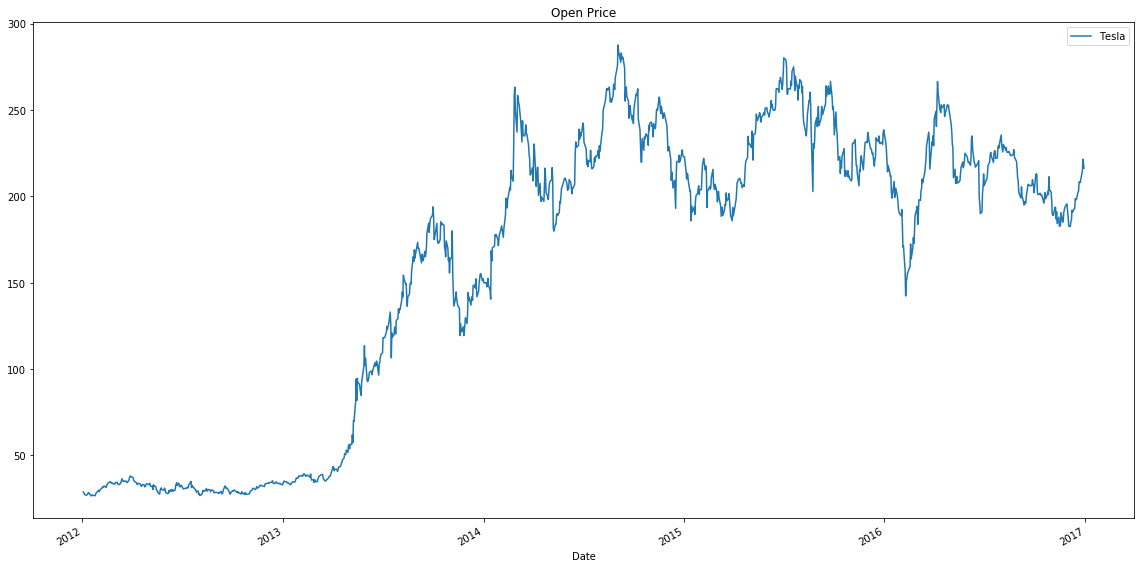

In [17]:
tesla['Open'].plot(label='Tesla',figsize=(16,8),title='Open Price')
plt.legend()
plt.tight_layout()

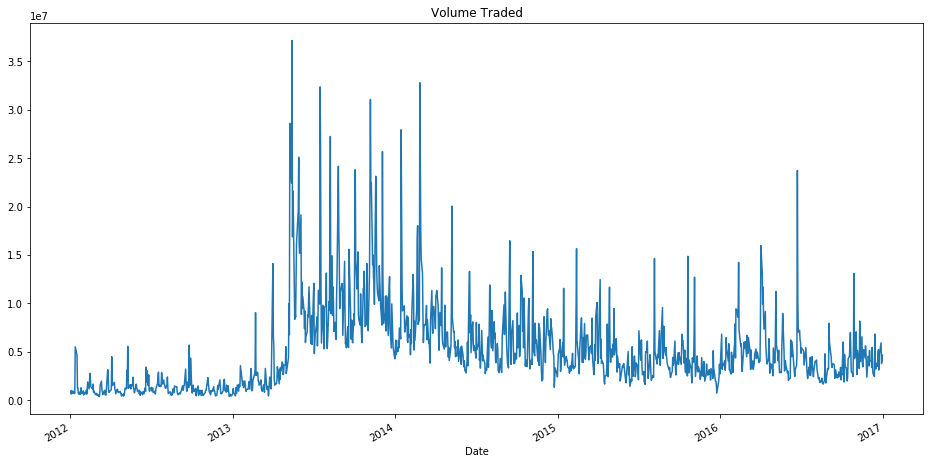

In [9]:
tesla['Volume'].plot(label='Tesla',figsize=(16,8),title='Volume Traded')

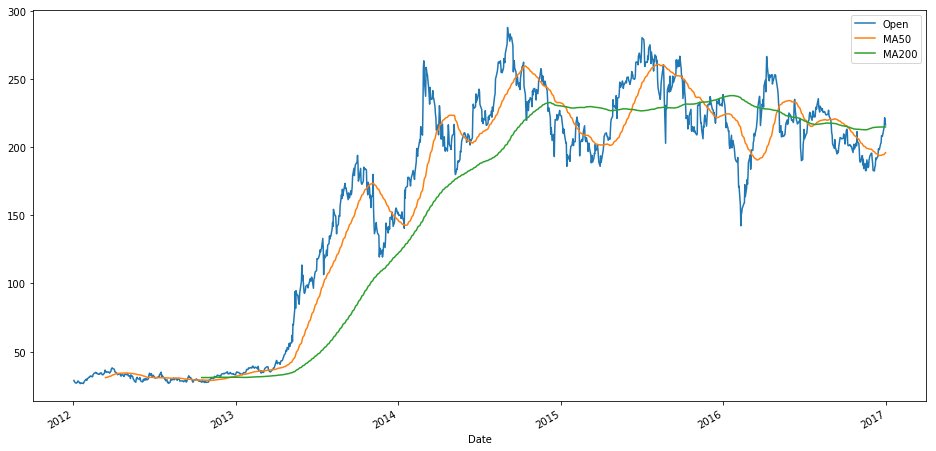

In [29]:
# Moving average of stock prices across time series
tesla['MA50'] = tesla['Open'].rolling(50).mean()
tesla['MA200'] = tesla['Open'].rolling(200).mean()
tesla[['Open','MA50','MA200']].plot(label='gm',figsize=(16,8))

In [30]:
tesla['returns'] = tesla['Close'].pct_change(1)

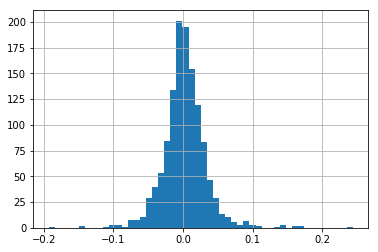

In [31]:
tesla['returns'].hist(bins=50)

In [47]:
# exploration is done so now we can call directly from the csv
tesla = pd.read_csv('Tesla_Stock.csv', sep=",")

In [61]:
tesla.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,28.94,29.50,27.65,28.08,928052
2012-01-04,28.21,28.67,27.50,27.71,630036
2012-01-05,27.76,27.93,26.85,27.12,1005432
2012-01-06,27.20,27.79,26.41,26.89,687081
2012-01-09,27.00,27.49,26.12,27.25,896951


In [311]:
tesla.dropna(inplace=True)

In [49]:
#tesla.index = pd.to_datetime(tesla.index)

In [312]:
tesla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
Open      1258 non-null float64
High      1258 non-null float64
Low       1258 non-null float64
Close     1258 non-null float64
Volume    1258 non-null int64
dtypes: float64(4), int64(1)
memory usage: 59.0 KB


In [370]:
tesla1 = tesla.drop(['Open', 'High', 'Low', 'Volume'], axis=1)
tesla1.head()

,Close
Date,
2012-01-03,28.08
2012-01-04,27.71
2012-01-05,27.12
2012-01-06,26.89
2012-01-09,27.25


In [371]:
tesla1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 1 columns):
Close    1258 non-null float64
dtypes: float64(1)
memory usage: 19.7 KB


In [372]:
train_set = tesla1.head(1253)
train_set.head()

,Close
Date,
2012-01-03,28.08
2012-01-04,27.71
2012-01-05,27.12
2012-01-06,26.89
2012-01-09,27.25


In [373]:
type(train_set)

pandas.core.frame.DataFrame

In [374]:
# we will be evaluating the test result for the last 5 days of the time series
test_set = tesla1.tail(5)

In [375]:
# Rescale the data before feeding into the model
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

In [376]:
train_scaled

array([[ 0.02009497],
       [ 0.01868946],
       [ 0.01644824],
       ..., 
       [ 0.70655271],
       [ 0.70241216],
       [ 0.70526116]])

In [318]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # Must limit the starting point to len(data)-steps
    # pick a random point to start for each batch
    rand_start = np.random.randint(0,len(training_data)-steps)
    
    
    # Now that we have a starting index we'll need to index the data from
    # the random start to random start + steps. Then reshape this data to be (1,steps) -- RNN TS format
    # This ensures that we will have the y batch in the batches ON THE TIME SERIES
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    
    
    # Return the batches. we'll have two batches to return y[:,:-1] and y[:,1:]
    # we'll need to reshape these into tensors for the RNN. Depending on your indexing it
    # will be either .reshape(-1,steps-1,1) or .reshape(-1,steps,1)
    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [378]:
# TF is graph-based so every time before running a new graph, we need to reset it
tf.reset_default_graph()

In [377]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch - variable dependent on how far we want to predict
num_time_steps = 5
# 300 neuron layer - variable
num_neurons = 300
# Just one output, predicted time series
num_outputs = 1

## try increasing iterations, but decreasing learning rate
# learning rate - varies
learning_rate = 0.00001 
# how many iterations to go through (training steps) - varies
num_train_iterations = 15000
# Size of the batch of data
batch_size = 1

In [379]:
# input and output placeholder
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [380]:
# using basic LSTM Cell
# activation function: relu

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

In [381]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [382]:
# Loss function
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [383]:
init = tf.global_variables_initializer()

In [384]:
saver = tf.train.Saver()

In [329]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)

In [385]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_ts_tesla5days_increaseLearnRate")

0 	MSE: 0.503946
100 	MSE: 0.0914303
200 	MSE: 0.00699186
300 	MSE: 0.00807252
400 	MSE: 0.299345
500 	MSE: 0.564088
600 	MSE: 0.515802
700 	MSE: 0.47161
800 	MSE: 0.399518
900 	MSE: 0.00144861
1000 	MSE: 0.368639
1100 	MSE: 0.388697
1200 	MSE: 0.325842
1300 	MSE: 0.196348
1400 	MSE: 0.201825
1500 	MSE: 0.0218266
1600 	MSE: 0.00807654
1700 	MSE: 0.00748159
1800 	MSE: 0.272155
1900 	MSE: 0.00751365
2000 	MSE: 0.231192
2100 	MSE: 0.210353
2200 	MSE: 0.208382
2300 	MSE: 0.00334152
2400 	MSE: 0.105723
2500 	MSE: 0.0346567
2600 	MSE: 0.147371
2700 	MSE: 0.0016097
2800 	MSE: 0.000642232
2900 	MSE: 0.179818
3000 	MSE: 0.177728
3100 	MSE: 0.125964
3200 	MSE: 0.0303195
3300 	MSE: 0.0907389
3400 	MSE: 0.153165
3500 	MSE: 0.00345992
3600 	MSE: 0.0826657
3700 	MSE: 0.0733612
3800 	MSE: 0.00483612
3900 	MSE: 0.128371
4000 	MSE: 0.0052558
4100 	MSE: 0.152865
4200 	MSE: 0.0975985
4300 	MSE: 0.0729545
4400 	MSE: 0.00614984
4500 	MSE: 0.015997
4600 	MSE: 0.0296016
4700 	MSE: 0.0486655
4800 	MSE: 0.0989

In [157]:
train_seed

[array([ 0.63008547]),
 array([ 0.61625831]),
 array([ 0.61435897]),
 array([ 0.63962013]),
 array([ 0.64710351]),
 array([ 0.66043685]),
 array([ 0.65842355]),
 array([ 0.63354226]),
 array([ 0.63289649]),
 array([ 0.60433048]),
 array([ 0.60277303]),
 array([ 0.62301994]),
 array([ 0.61941121]),
 array([ 0.6471415]),
 array([ 0.64387464]),
 0.64226747,
 0.64035535,
 0.63790601,
 0.63523412,
 0.63260907,
 0.63008219,
 0.62770325,
 0.62550592,
 0.62334704,
 0.62128478,
 0.61919504,
 0.61702424,
 0.61486405,
 0.61262763,
 0.61043555]

In [387]:
# Inverse Scaling the result to have the actual stock price
results = scaler.inverse_transform(np.array(train_seed[5:]).reshape(5,1))

In [388]:
test_set['Generated'] = results

/home/hugh/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [391]:
test_set

,Close,Generated
Date,,
2016-12-23,213.34,210.697815
2016-12-27,219.53,212.016434
2016-12-28,219.74,214.188873
2016-12-29,214.68,215.764481
2016-12-30,213.69,217.487793


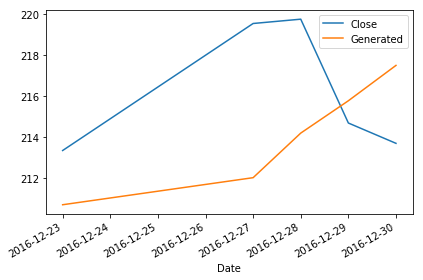

In [390]:
plt.figure(figsize=(12,10))
test_set.plot()
plt.tight_layout()

# Experiment with Periodic Behaviour: Sin Function

In [3]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points 
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        # useful to compare the data that we do not have
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # generate a random starting point for each batch
        rand_start = np.random.rand(batch_size,1) 
        
        # making sure the starting point be on time series
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution) )
        
        # Create batch ts on the x axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data associating with the batch_ts time series 
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        if return_batch_ts:
            # return the y_batch along with batch_ts
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
            # include the 3rd element batch_ts if we also want the info of x axis
        else:
            
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
            # y_batch[:, :-1].reshape(-1, steps, 1) represent the time series
            # y_batch[:, 1:].reshape(-1, steps, 1) represents the time series shifted 1 step forward

In [4]:
ts_data = TimeSeriesData(300,0,10)

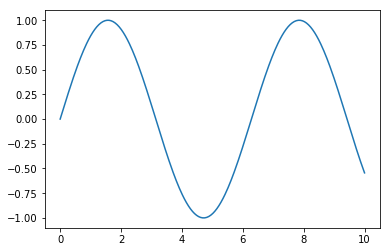

In [5]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [6]:
ts_data

In [7]:
# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 30

In [8]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True) 
# True means that we want y_batch along with batch_ts
# y1 current time series
# y2 time series shifted 1 forward

In [9]:
type(y1)

numpy.ndarray

In [10]:
ts

array([[ 7.11842801,  7.15176134,  7.18509468,  7.21842801,  7.25176134,
         7.28509468,  7.31842801,  7.35176134,  7.38509468,  7.41842801,
         7.45176134,  7.48509468,  7.51842801,  7.55176134,  7.58509468,
         7.61842801,  7.65176134,  7.68509468,  7.71842801,  7.75176134,
         7.78509468,  7.81842801,  7.85176134,  7.88509468,  7.91842801,
         7.95176134,  7.98509468,  8.01842801,  8.05176134,  8.08509468,
         8.11842801]])

In [11]:
ts.flatten()

array([ 7.11842801,  7.15176134,  7.18509468,  7.21842801,  7.25176134,
        7.28509468,  7.31842801,  7.35176134,  7.38509468,  7.41842801,
        7.45176134,  7.48509468,  7.51842801,  7.55176134,  7.58509468,
        7.61842801,  7.65176134,  7.68509468,  7.71842801,  7.75176134,
        7.78509468,  7.81842801,  7.85176134,  7.88509468,  7.91842801,
        7.95176134,  7.98509468,  8.01842801,  8.05176134,  8.08509468,
        8.11842801])

In [12]:
y2.shape

(1, 30, 1)

In [13]:
y1.shape

(1, 30, 1)

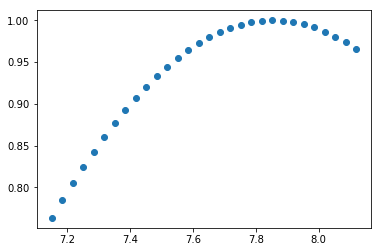

In [14]:
plt.plot(ts.flatten()[1:],y2.flatten(),'o')

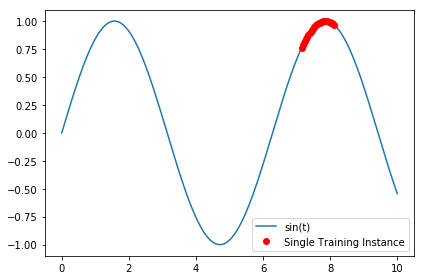

In [15]:
plt.plot(ts_data.x_data,ts_data.y_true,label='sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'ro',label='Single Training Instance')
plt.legend()
plt.tight_layout()

### A Training Instance and what to predict

We are trying to predict a time series shifted over by t+1

In [16]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps + 3), num_time_steps+3)

In [17]:
train_inst

array([ 5.      ,  5.034375,  5.06875 ,  5.103125,  5.1375  ,  5.171875,
        5.20625 ,  5.240625,  5.275   ,  5.309375,  5.34375 ,  5.378125,
        5.4125  ,  5.446875,  5.48125 ,  5.515625,  5.55    ,  5.584375,
        5.61875 ,  5.653125,  5.6875  ,  5.721875,  5.75625 ,  5.790625,
        5.825   ,  5.859375,  5.89375 ,  5.928125,  5.9625  ,  5.996875,
        6.03125 ,  6.065625,  6.1     ])

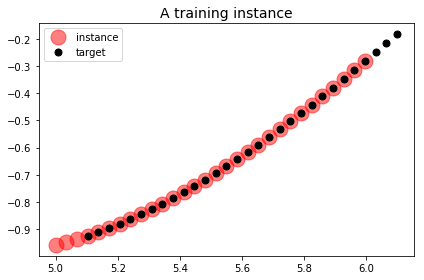

In [18]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-3], ts_data.ret_true(train_inst[:-3]), "ro", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[3:], ts_data.ret_true(train_inst[3:]), "ko", markersize=7, label="target")
plt.legend()
plt.tight_layout()

___________

# Creating the Model

In [19]:
tf.reset_default_graph()

### Constants

In [20]:
# Just one feature, the time series: given x, what is y
num_inputs = 1
# 100 neuron layer- varies: this will in turn output 100 output (time series)
# but we only need 1 output/time series so we will need PRJOECT WRAPPER
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default- varies
learning_rate = 0.0001
# how many iterations to go through (training steps)- varies
num_train_iterations = 2700
# Size of the batch of data
batch_size = 1

### Placeholders

In [21]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs]) 
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

____
____
### RNN Cell Layer

##### Try different cell to see how the performance change

In [51]:
#cell = tf.contrib.rnn.OutputProjectionWrapper(
#    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
#    output_size=num_outputs) # output size here we need only 1

In [22]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

_____
_____

In [23]:
#Dynamic cell:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
# dynamic rnn using the declared cell
# automatically output BOTH the output and the state of the cell
# it performs the dynamic unrolling of the inputs --> using while loop ops to run over the cell appropriate times

In [24]:
outputs

<tf.Tensor 'rnn/transpose:0' shape=(?, 30, 1) dtype=float32>

In [25]:
states

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 100) dtype=float32>)

### Loss Function and Optimizer

In [26]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

#### Init Variables

In [27]:
init = tf.global_variables_initializer()

## Session

In [28]:
# GPU setup
# https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)

In [29]:
saver = tf.train.Saver()

In [30]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_hq2n_LSTM_3fwd")

0 	MSE: 0.93437
100 	MSE: 0.428656
200 	MSE: 0.0916274
300 	MSE: 0.240879
400 	MSE: 0.155329
500 	MSE: 0.134925
600 	MSE: 0.0257838
700 	MSE: 0.0324884
800 	MSE: 0.0255347
900 	MSE: 0.0820185
1000 	MSE: 0.00725256
1100 	MSE: 0.00818381
1200 	MSE: 0.0673857
1300 	MSE: 0.0286149
1400 	MSE: 0.0548196
1500 	MSE: 0.0437685
1600 	MSE: 0.0169714
1700 	MSE: 0.0146078
1800 	MSE: 0.00362192
1900 	MSE: 0.0326713
2000 	MSE: 0.00184243
2100 	MSE: 0.00303575
2200 	MSE: 0.0330177
2300 	MSE: 0.0421146
2400 	MSE: 0.0042057
2500 	MSE: 0.0246824
2600 	MSE: 0.00167243


### Predicting a time series t+3

In [34]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_hq2n_LSTM_3fwd")   

    X_new = np.sin(np.array(train_inst[:-3].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_hq2n_LSTM_3fwd


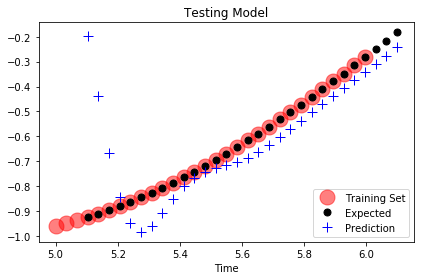

In [35]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-3], np.sin(train_inst[:-3]), "ro", markersize=15,alpha=0.5, label="Training Set")

# Target to Predict
plt.plot(train_inst[3:], np.sin(train_inst[3:]), "ko", markersize=7, label="Expected")

# Models Prediction
plt.plot(train_inst[3:], y_pred[0,:,0], "b+", markersize=10, label="Prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()
fig = plt.figure(figsize = (12,10))